
# 0. IMPORTS E CONFIGURAÇÃO GLOBAL


In [1]:
import numpy as np
import pandas as pd
import shap

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_predict,KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

In [2]:
# Configurações
RANDOM_STATE = 42
TEST_SIZE = 0.2
FILE_PATH = "./content/dados_jamovi.xlsx"
TARGET_COL = "Velocity (mean) [µm/s]"

# Parametros do modelo
GBR_PARAMS = dict(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)

# Constantes físicas
RHO_F = 1000.0  # Fluid density (kg/m³)
MU = 0.001      # Dynamic viscosity (Pa·s)
G = 9.81        # Gravity (m/s²)
RHO_P = 2600.0  # Particle density (kg/m³)


# 1. FUNCÕES UTILITARIAS 

## Carregamento e pré-processamento de dados

In [ ]:
def load_data(file_path, target_col):
    """
    Carrega dados de um arquivo Excel e separa features e target.

    Parâmetros
    ----------
    file_path : str
        Caminho do arquivo Excel.
    target_col : str
        Nome da coluna alvo.

    Retorno
    -------
    data : DataFrame
        DataFrame completo.
    X : DataFrame
        Features numéricas (exclui o target).
    y : Series
        Variável alvo.
    """
    data = pd.read_excel(file_path)

    if target_col not in data.columns:
        raise ValueError(f"Target not found: {target_col}")

    numeric_data = data.select_dtypes(include=[np.number])
    
    X = numeric_data.drop(columns=[target_col])
    y = numeric_data[target_col]

    return data, X, y



In [ ]:
def handle_missing_values(
    X, y,
    strategy="impute",
    impute_method="mean",
    imputer=None,
    verbose=True
):
    """
    Trata valores ausentes em X e y.

    Permite remover linhas com NaN ou imputar valores faltantes em X.

    Parâmetros
    ----------
    X : DataFrame
        Matriz de features.
    y : Series
        Variável alvo.
    strategy : {"impute", "drop"}, default="impute"
        Estratégia de tratamento.
    impute_method : str, default="mean"
        Método de imputação (quando strategy="impute").
    imputer : SimpleImputer ou None
        Imputador pré-ajustado.
    verbose : bool
        Exibe resumo da operação.

    Retorno
    -------
    X_clean : DataFrame
        Features preditoras com nulos tratados
    y_clean : Series
        Feature alvo com nulos tratados
    imputer : SimpleImputer ou None
        Imputador utilizado
    """


    if strategy == "drop":
        mask = X.notna().all(axis=1) & y.notna()
        X_clean = X.loc[mask].copy()
        y_clean = y.loc[mask].copy()

        if verbose:
            print(f"Dropped {len(X) - len(X_clean)} rows with missing values")

        return X_clean, y_clean, None

    elif strategy == "impute":
        if imputer is None:
            imputer = SimpleImputer(strategy=impute_method)
            X_clean = pd.DataFrame(
                imputer.fit_transform(X),
                columns=X.columns,
                index=X.index
            )
        else:
            X_clean = pd.DataFrame(
                imputer.transform(X),
                columns=X.columns,
                index=X.index
            )

        if y.isna().any():
            raise ValueError("Target y contains NaNs. Handle before fitting.")

        if verbose:
            print(f"Imputed missing values using strategy: {impute_method}")

        return X_clean, y.copy(), imputer

    else:
        raise ValueError("strategy must be 'drop' or 'impute'")


## Treinamento e avaliação de modelos

In [ ]:
def evaluate(y_true, y_pred):
    """
    Calcula métricas de avaliação de regressão.

    Parâmetros
    ----------
    y_true : array-like
        Valores observados.
    y_pred : array-like
        Valores preditos pelo modelo.

    Retorno
    -------
    dict
        Dicionário com MAE, RMSE e R².
    """
    
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

In [ ]:
def gbr_train_predict(X_train, y_train, X_test, params):
    """
    Treina um Gradient Boosting Regressor e gera predições.

    Parâmetros
    ----------
    X_train : array-like
        Features de treino.
    y_train : array-like
        Variável alvo de treino.
    X_test : array-like
        Features para predição.
    params : dict
        Hiperparâmetros do modelo.

    Retorno
    -------
    y_pred : array
        Predições no conjunto de teste.
    model : GradientBoostingRegressor
        Modelo treinado.
    """
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    return model.predict(X_test), model 

## Visualização gráfica de resultados

In [ ]:
def plot_predicted_vs_observed(
    df_trad,
    df_pfe,
    y_true_col="y_true",
    y_pred_col="y_pred",
    figsize=(7, 6),
):
    """
    Plota valores preditos versus observados para dois modelos.

    Compara o modelo tradicional e o modelo com PFE
    em um gráfico de dispersão com linha 1:1.

    Parâmetros
    ----------
    df_trad : pandas.DataFrame
        Resultados de avaliação do modelo tradicional.
    df_pfe : pandas.DataFrame
        Resultados de avaliação do modelo com PFE.
    y_true_col : str, default="y_true"
        Nome da coluna com os valores observados.
    y_pred_col : str, default="y_pred"
        Nome da coluna com os valores preditos.
    figsize : tuple, default=(7, 6)
        Tamanho da figura.

    Retorno
    -------
    None
        Exibe o gráfico.
    """

    plt.figure(figsize=figsize)

    for df_, label, marker, size in [
        (df_trad, "Traditional GBR", "x", 12),
        (df_pfe, "PFE-GBR", "*", 20),
    ]:
        plt.scatter(
            df_[y_true_col],
            df_[y_pred_col],
            marker=marker,
            s=size,
            alpha=0.7,
            label=label,
        )

    # Combine results to define global limits
    df_all = pd.concat([df_trad, df_pfe], axis=0)

    lims = [
        min(df_all[y_true_col].min(), df_all[y_pred_col].min()),
        max(df_all[y_true_col].max(), df_all[y_pred_col].max()),
    ]

    plt.plot(lims, lims, linestyle="--")
    plt.xlim([lims[0] - 1 * lims[0], lims[1] + 0.05 * lims[1]])
    plt.ylim([lims[0] - 1 * lims[0], lims[1] + 0.05 * lims[1]])

    plt.xlabel("Velocidade observada (µm/s)")
    plt.ylabel("Velocidade predita (µm/s)")
    plt.title("Predito vs Observado")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_residuals_vs_prediction(
    df_trad,
    df_pfe,
    y_pred_col="y_pred",
    residuals_col="residuals",
    figsize=(7, 6),
):
    """
    Plota resíduos em função dos valores preditos para dois modelos.

    Permite avaliar viés, heterocedasticidade e padrões
    sistemáticos nos resíduos.

    Parâmetros
    ----------
    df_trad : pandas.DataFrame
        Resultados de avaliação do modelo tradicional.
    df_pfe : pandas.DataFrame
        Resultados de avaliação do modelo com PFE.
    y_pred_col : str, default="y_pred"
        Nome da coluna com os valores preditos.
    residuals_col : str, default="residuals"
        Nome da coluna com os resíduos (observado - predito).
    figsize : tuple, default=(7, 6)
        Tamanho da figura.

    Retorno
    -------
    None
        Exibe o gráfico.
    """

    plt.figure(figsize=figsize)

    for df_, label, marker, size in [
        (df_trad, "Traditional GBR", "x", 12),
        (df_pfe, "PFE-GBR", "*", 20),
    ]:
        plt.scatter(
            df_[y_pred_col],
            df_[residuals_col],
            marker=marker,
            s=size,
            alpha=0.7,
            label=label,
        )

    plt.axhline(0, linestyle="--")

    plt.xlabel("Velocidade predita (µm/s)")
    plt.ylabel("Resíduo (observado - predito)")
    plt.title("Resíduos vs Velocidade predita")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Validação estatistica e incerteza

In [ ]:
def bootstrap_mae(
    y_true,
    y_pred,
    n_boot=100,
    random_state=42
):
    """
    Calcula distribuição bootstrap do MAE.

    Retorna média, desvio padrão e intervalo de confiança (95%).

    Parâmetros
    ----------
    y_true : array-like
        Valores observados.
    y_pred : array-like
        Valores preditos pelo modelo (fixos).
    n_boot : int
        Número de reamostragens bootstrap.
    random_state : int
        Seed para reprodutibilidade.

    Retorna
    -------
    dict com:
        mae_boot : np.ndarray
        mean_mae : float
        std_mae  : float
        ci_low   : float (IC 2.5%)
        ci_high  : float (IC 97.5%)
    """
    rng = np.random.default_rng(random_state)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true e y_pred devem ter o mesmo tamanho")

    n = len(y_true)
    mae_boot = np.empty(n_boot)

    for i in range(n_boot):
        idx = rng.integers(0, n, size=n)  # amostragem com reposição
        mae_boot[i] = mean_absolute_error(
            y_true[idx],
            y_pred[idx]
        )

    mean_mae = mae_boot.mean()
    std_mae  = mae_boot.std(ddof=1)
    ci_low, ci_high = np.percentile(mae_boot, [2.5, 97.5])

    return {
        "mae_boot": mae_boot,
        "mean_mae": mean_mae,
        "std_mae": std_mae,
        "ci_low": ci_low,
        "ci_high": ci_high
    }


## Experimentos adicionais

In [ ]:
def run_noise_experiment(
    gaussian_level,
    file_path,
    target_col,
    gbr_params,
    random_state=42,
    n_splits=5,
):
    """
    Executa experimento de ruído gaussiano com PFE + GBR.

    Pipeline:
    - carrega os dados
    - aplica engenharia de features baseada em física com ruído
    - trata valores ausentes
    - avalia o modelo via validação cruzada

    Parâmetros
    ----------
    gaussian_level : float
        Intensidade do ruído gaussiano aplicado nas features físicas.
    file_path : str
        Caminho do arquivo de dados.
    target_col : str
        Nome da variável alvo.
    gbr_params : dict
        Hiperparâmetros do Gradient Boosting Regressor.
    random_state : int, default=42
        Seed para reprodutibilidade.
    n_splits : int, default=5
        Número de folds da validação cruzada.

    Retorno
    -------
    dict
        Dicionário com o nível de ruído e as métricas MAE, RMSE e R².
    """

    # 1. Load data
    _, X, y = load_data(file_path, target_col)

    # 2. Physics Feature Engineering with noise
    pfe = PhysicsFeatureEngineer(
        use_diameter=False,
        use_r2=False,
        rho_f=RHO_F,
        mu=MU,
        g=G,
        gaussian_noise=True,
        gaussian_level=gaussian_level,
    )

    X_pfe = pfe.fit_transform(X, y)

    # 3. Handle missing values
    X_pfe, y, _ = handle_missing_values(
        X_pfe,
        y,
        strategy="impute",
        impute_method="mean",
    )

    # 4. Cross-validation
    model = GradientBoostingRegressor(**gbr_params)
    kfold = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    cv_pred = cross_val_predict(
        model,
        X_pfe,
        y,
        cv=kfold
    )

    # 5. Metrics
    return {
        "noise_level": gaussian_level,
        "MAE": mean_absolute_error(y, cv_pred),
        "RMSE": np.sqrt(mean_squared_error(y, cv_pred)),
        "R2": r2_score(y, cv_pred),
    }


# 2. CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS

In [10]:
# Load data
data, X, y = load_data(FILE_PATH, TARGET_COL)

# Handle missing values
X, y, imputer = handle_missing_values(X, y, strategy="impute", impute_method="mean")


Imputed missing values using strategy: mean


# 3. ENGENHARIA DE FEATURES

In [ ]:
class PhysicsFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformer do scikit-learn para geração de features baseadas em física.

    Calcula grandezas físicas (Re, Cd, Fd e termos geométricos)
    a partir de medições de partículas, podendo opcionalmente
    injetar ruído gaussiano nos dados e/ou no alvo.

    Parâmetros
    ----------
    use_diameter : bool, default=True
        Usa o diâmetro como comprimento característico.
        Se False, usa o raio.
    use_r2 : bool, default=True
        Inclui o termo r² como feature. Se False, usa r.
    rho_f : float
        Densidade do fluido (kg/m³).
    rho_p : float
        Densidade da partícula (kg/m³).
    mu : float
        Viscosidade dinâmica do fluido (Pa·s).
    g : float
        Aceleração da gravidade (m/s²).
    gaussian_noise : bool, default=False
        Indica se ruído gaussiano deve ser aplicado.
    gaussian_level : float or None
        Intensidade relativa do ruído gaussiano.
    noise_seed : int, default=42
        Seed para reprodutibilidade do ruído.
    noise_on_target : bool, default=True
        Aplica ruído também na variável alvo.

    Atributos
    ----------
    feature_names_ : list
        Nomes das features físicas geradas.
    y_ : pandas.Series
        Variável alvo armazenada durante o fit.
    """

    def __init__(
        self, 
        use_diameter=True, 
        use_r2=True,
        rho_f=RHO_F, 
        rho_p=RHO_P, 
        mu=MU, 
        g=G, 
        gaussian_noise=False,
        gaussian_level=None,
        noise_seed=42,
        noise_on_target=True
    ):
        self.use_diameter = use_diameter
        self.use_r2 = use_r2
        self.rho_f = rho_f
        self.rho_p = rho_p
        self.mu = mu
        self.g = g
        self.gaussian_noise = gaussian_noise
        self.gaussian_level = gaussian_level
        self.noise_seed = noise_seed
        self.noise_on_target = noise_on_target
        
    def fit(self, X, y):
        """
        Ajusta o transformer armazenando explicitamente o alvo.

        Este transformer utiliza intencionalmente a variável alvo
        para gerar features físicas.

        Parâmetros
        ----------
        X : pandas.DataFrame
            Dados de entrada.
        y : array-like
            Variável alvo.

        Retorno
        -------
        self
            Instância ajustada.
        """

        if y is None:
            raise ValueError(
                "PhysicsFeatureEngineerWithTarget requires `y` in fit(). "
                "This transformer intentionally uses the target variable."
            )

        # Store y as pandas Series aligned with X
        self.y_ = pd.Series(y, index=X.index, name="velocity")

        self.feature_names_ = [
            "PFE_Re",
            "PFE_Cd",
            "PFE_Fd",
            "PFE_r2" if self.use_r2 else "PFE_r"
        ]

        return self
    
    def transform(self, X):
        """
        Aplica a engenharia de features físicas aos dados.

        Utiliza o alvo armazenado no `fit` para o cálculo
        das grandezas físicas.

        Parâmetros
        ----------
        X : pandas.DataFrame
            Dados de entrada.

        Retorno
        -------
        pandas.DataFrame
            DataFrame com features originais e físicas adicionadas.
        """

        if not hasattr(self, "y_"):
            raise RuntimeError("Transformer must be fitted before calling transform().")

        X_ = X.copy()
        y_ = self.y_.copy()

        # Noise Injection 
        if self.gaussian_noise: 
            X_,y_ = self._apply_gaussian_noise(X_, y_)

        # Compute physics features
        physics_features = self._compute_physics_features(X_, y_)
        
    
        return pd.concat([X_, physics_features], axis=1)


    def fit_transform(self, X, y, **fit_params):
        """
        Ajusta o transformer e aplica a transformação em uma única etapa.

        Parâmetros
        ----------
        X : pandas.DataFrame
            Dados de entrada.
        y : array-like
            Variável alvo.

        Retorno
        -------
        pandas.DataFrame
            DataFrame com features originais e físicas adicionadas.
        """
    
        return self.fit(X, y).transform(X)
    
    def _apply_gaussian_noise(self, X, y):
        """
        Aplica ruído gaussiano multiplicativo às variáveis selecionadas.

        O ruído pode ser aplicado apenas às features ou também
        à variável alvo, dependendo da configuração.

        Parâmetros
        ----------
        X : pandas.DataFrame
            Dados de entrada.
        y : pandas.Series
            Variável alvo.

        Retorno
        -------
        X_noisy : pandas.DataFrame
            Dados com ruído aplicado.
        y_noisy : pandas.Series
            Alvo com ruído aplicado (se configurado).
        """

        if self.gaussian_level is None:
            raise ValueError ("`gaussian_level` must be provided when gaussian_noise=True")

        rng = np.random.default_rng(self.noise_seed)

        sigma = self.gaussian_level

        def noisy(var): 
            return var * (1.0 + rng.normal(0.0, sigma, size=len(var)))
        
        X["Radius (max) (mean) [µm]"] = noisy(X["Radius (max) (mean) [µm]"])
        X["Area (mean) [µm²]"] = noisy(X["Area (mean) [µm²]"])

        if self.noise_on_target:
            y = noisy(y)

        return X, y

    def _compute_physics_features(self, df, y=None):
        """
        Calcula as features físicas a partir dos dados de entrada.

        Grandezas calculadas:
        - Número de Reynolds (Re)
        - Coeficiente de arrasto (Cd)
        - Força de arrasto (Fd)
        - Termo geométrico (r ou r²)

        Parâmetros
        ----------
        df : pandas.DataFrame
            Dados de entrada com medições das partículas.
        y : array-like
            Variável alvo (velocidade).

        Retorno
        -------
        pandas.DataFrame
            DataFrame contendo apenas as features físicas.
        """

        if y is None:
            raise ValueError(
                "This PFE configuration requires the target variable y."
            )
        
        # Extract and convert units
        A = df["Area (mean) [µm²]"] * 1e-12
        r = df["Radius (max) (mean) [µm]"] * 1e-6
        v = y * 1e-6  # µm/s → m/s (INTENTIONAL LEAKAGE)
        
        # Calculate characteristic length
        if self.use_diameter:
            d = 2.0 * np.sqrt(A / np.pi)
            characteristic_length = d
        else:
            characteristic_length = r
        
        # Reynolds number
        Re = (self.rho_f * v * characteristic_length) / self.mu
        Re = Re.where(Re > 0).replace([np.inf, -np.inf], np.nan)
        
        # Drag coefficient (Stokes regime)
        Cd = 24.0 / Re
        
        # Drag force
        Fd = 0.5 * self.rho_f * Cd * A * v**2
        
        # Radius or radius squared (configurable)
        if self.use_r2:
            r_feat = r**2
            r_feat_name = "PFE_r2"
        else:
            r_feat = r
            r_feat_name = "PFE_r"
        
        return pd.DataFrame({
            "PFE_Re": Re,
            "PFE_Cd": Cd,
            "PFE_Fd": Fd,
            r_feat_name: r_feat
        }, index=df.index)
    
    def get_feature_names_out(self, input_features=None):
        """
        Retorna os nomes das features após a transformação.

        Parâmetros
        ----------
        input_features : array-like of str, optional
            Nomes das features de entrada.

        Retorno
        -------
        numpy.ndarray
            Nomes das features de saída.
        """
        
        if input_features is None:
            return np.array(self.feature_names_)
        else:
            return np.concatenate([input_features, self.feature_names_])

In [12]:
# versao anterior - para backup caso a versao acima quebre
# class PhysicsFeatureEngineer(BaseEstimator, TransformerMixin):
#     """
#     Scikit-learn transformer for computing physics-based features from particle data.

#     Parameters:
#     -----------
#     target_col : str
#         Name of velocity column in the original dataframe
#     use_diameter : bool, default=True
#         If True, use diameter formula (new); if False, use radius directly (old)
#     rho_f : float, default=1000.0
#         Fluid density (kg/m³)
#     rho_p : float, default=2500.0
#         Particle density (kg/m³)
#     mu : float, default=0.001
#         Dynamic viscosity (Pa·s)
#     g : float, default=9.81
#         Gravitational acceleration (m/s²)

#     Attributes:
#     -----------
#     feature_names_ : list
#         Names of the generated physics features
#     """

#     def __init__(
#         self,
#         use_diameter=True,
#         use_r2=True,
#         rho_f=RHO_F,
#         rho_p=RHO_P,
#         mu=MU,
#         g=G
#     ):
#         self.use_diameter = use_diameter
#         self.use_r2 = use_r2
#         self.rho_f = rho_f
#         self.rho_p = rho_p
#         self.mu = mu
#         self.g = g

#     def fit(self, X, y):
#         """
#         Parameters:
#         -----------
#         X : DataFrame
#             Input data (not used, but stored for reference)
#         y : array-like
#             Target values

#         Returns:
#         --------
#         Store target variable explicitly.
#         """
#         if y is None:
#             raise ValueError(
#                 "PhysicsFeatureEngineerWithTarget requires y in fit(). "
#                 "This transformer intentionally uses the target variable."
#             )

#         # Store y as pandas Series aligned with X
#         self.y_ = pd.Series(y, index=X.index, name="velocity")

#         self.feature_names_ = [
#             "PFE_Re",
#             "PFE_Cd",
#             "PFE_Fd",
#             "PFE_r2" if self.use_r2 else "PFE_r",
#         ]

#         return self

#     def transform(self, X):
#         """
#         Transform the input data by adding physics features.
#         Transform X using stored target values.

#         Parameters:
#         -----------
#         X : DataFrame
#             Input data with particle measurements

#         Returns:
#         --------
#         DataFrame with original features plus physics features
#         """
#         if not hasattr(self, "y_"):
#             raise RuntimeError(
#                 "Transformer must be fitted before calling transform()."
#             )

#         # Compute physics features
#         physics_features = self._compute_physics_features(X)

#         return pd.concat([X, physics_features], axis=1)

#     def fit_transform(self, X, y, **fit_params):
#         """
#         Fit and transform in one step.

#         Parameters:
#         -----------
#         X : DataFrame
#             Input data with particle measurements
#         y : array-like, optional
#             Target values (not used)

#         Returns:
#         --------
#         DataFrame with original features plus physics features
#         """
#         return self.fit(X, y).transform(X)

#     def _compute_physics_features(self, df):
#         """
#         Internal method to compute physics-based features.

#         Parameters:
#         -----------
#         df : DataFrame
#             Input data with particle measurements

#         Returns:
#         --------
#         DataFrame with physics features
#         """
#         # Extract and convert units
#         A = df["Area (mean) [µm²]"] * 1e-12
#         r = df["Radius (max) (mean) [µm]"] * 1e-6
#         v = self.y_ * 1e-6  # µm/s → m/s (INTENTIONAL LEAKAGE)

#         # Calculate characteristic length
#         if self.use_diameter:
#             d = 2.0 * np.sqrt(A / np.pi)
#             characteristic_length = d
#         else:
#             characteristic_length = r

#         # Reynolds number
#         Re = (self.rho_f * v * characteristic_length) / self.mu
#         Re = Re.where(Re > 0).replace([np.inf, -np.inf], np.nan)

#         # Drag coefficient (Stokes regime)
#         Cd = 24.0 / Re

#         # Drag force
#         Fd = 0.5 * self.rho_f * Cd * A * v**2

#         # Radius or radius squared (configurable)
#         if self.use_r2:
#             r_feat = r**2
#             r_feat_name = "PFE_r2"
#         else:
#             r_feat = r
#             r_feat_name = "PFE_r"

#         return pd.DataFrame(
#             {
#                 "PFE_Re": Re,
#                 "PFE_Cd": Cd,
#                 "PFE_Fd": Fd,
#                 r_feat_name: r_feat,
#             },
#             index=df.index,
#         )

#     def get_feature_names_out(self, input_features=None):
#         """
#         Get output feature names for transformation.

#         Parameters:
#         -----------
#         input_features : array-like of str, optional
#             Input feature names

#         Returns:
#         --------
#         array of str
#             Output feature names
#         """
#         if input_features is None:
#             return np.array(self.feature_names_)
#         else:
#             return np.concatenate([input_features, self.feature_names_])


# 4. EXPERIMENTO 1 - CROSS VALIDATION

## Configuracao experimental


In [13]:
# Cross-validation
model_cv = GradientBoostingRegressor(**GBR_PARAMS)
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Modelo 1 - Tradicional GBR (Baseline)

In [14]:
cv_pred_a = cross_val_predict(model_cv, X, y, cv=kfold)


In [15]:
# Create evaluation dataframes
df_cv_trad = pd.DataFrame({
    "y_pred": cv_pred_a,
    "y_true": y.reset_index(drop=True),
    "residuals": y.reset_index(drop=True) - cv_pred_a,
    "model": "Traditional"
})

## Modelo 2 - PFE - GBR

In [16]:
# Create the transformer
pfe = PhysicsFeatureEngineer(
    use_diameter=False,
    rho_f=RHO_F, 
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_pfe = pfe.fit_transform(X,y)

In [17]:
cv_pred_b = cross_val_predict(model_cv, X_pfe, y, cv=kfold)

In [18]:

# Create evaluation dataframes
df_cv_pfe = pd.DataFrame({
    "y_pred": cv_pred_b,
    "y_true": y.reset_index(drop=True),
    "residuals": y.reset_index(drop=True) - cv_pred_b,
    "model": "PFE"
})


## Comparacao de resultados

In [19]:
# Evaluate CV results
cv_results = pd.DataFrame.from_dict({
    "Traditional GBR (CV)": evaluate(df_cv_trad['y_true'], df_cv_trad['y_pred']),
    "PFE-GBR (CV)": evaluate(df_cv_pfe['y_true'], df_cv_pfe['y_pred'])
}, orient="index")

print(cv_results)

                             MAE        RMSE        R2
Traditional GBR (CV)  234.314568  397.489626  0.886877
PFE-GBR (CV)          135.693109  262.877990  0.950523


## Real vs Predicted Velocity 

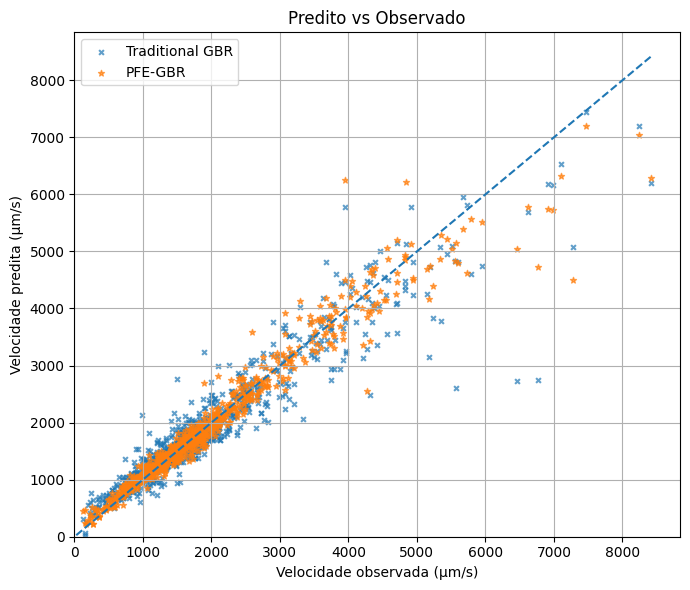

In [20]:
plot_predicted_vs_observed(df_cv_trad, df_cv_pfe)


## Error Analysis


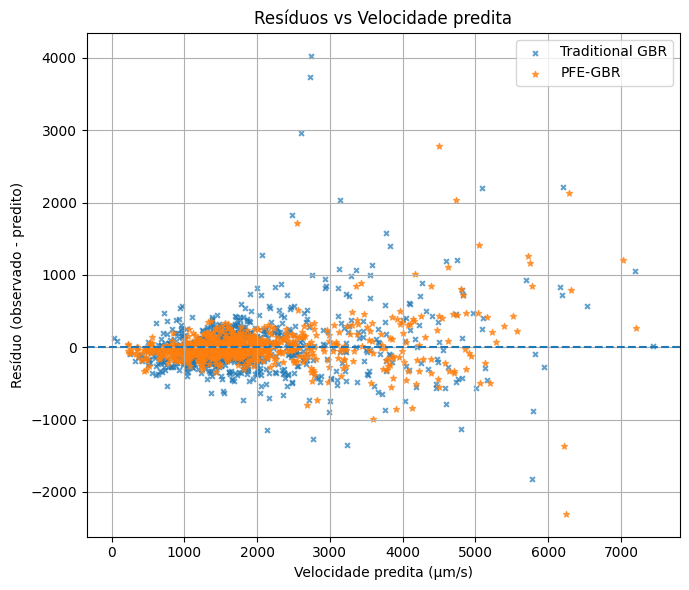

In [21]:
plot_residuals_vs_prediction(df_cv_trad, df_cv_pfe)

# 5. EXPERIMENTO 2 - VALIDACAO HOLDOUT

## Split train and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## Modelo 1 - Traditional GBR (Baseline)


### Train and predict 

In [23]:
y_pred_trad, trad_gbr_model = gbr_train_predict(X_train, y_train, X_test, GBR_PARAMS)

df_eval_trad = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_trad,
    "residuals": y_test - y_pred_trad,
    "experiment": "Traditional GBR"
})



## Modelo 2 - PFE - GBR


### Feature Engineering - Phisical features

In [24]:
# Create the transformer
pfe = PhysicsFeatureEngineer(
    use_diameter=False,
    rho_f=RHO_F,  # Use your constants
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_train_pfe = pfe.fit_transform(X_train,y)
X_test_pfe = pfe.fit_transform(X_test,y)

### Training and model

In [25]:
y_pred_pfe, pfe_gbr_model = gbr_train_predict(X_train_pfe, y_train, X_test_pfe, GBR_PARAMS)

df_eval_pfe = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_pfe,
    "residuals": y_test - y_pred_pfe,
    "experiment": "PFE-GBR"
})


## Comparação dos resultados (conjunto de teste)

In [26]:
results = pd.DataFrame.from_dict({
    "Traditional GBR": evaluate(y_test, y_pred_trad),
    "PFE-GBR": evaluate(y_test, y_pred_pfe)
}, orient="index")

results

,MAE,RMSE,R2
Traditional GBR,232.035470,371.830841,0.916006
PFE-GBR,143.816686,311.426022,0.941079


## Real vs Predicted Velocity 

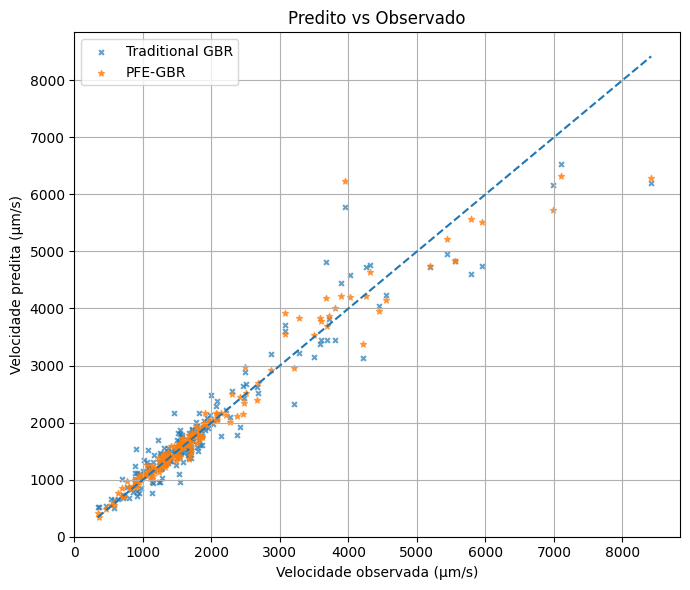

In [27]:
plot_predicted_vs_observed(df_eval_trad, df_eval_pfe)


## Error Analysis


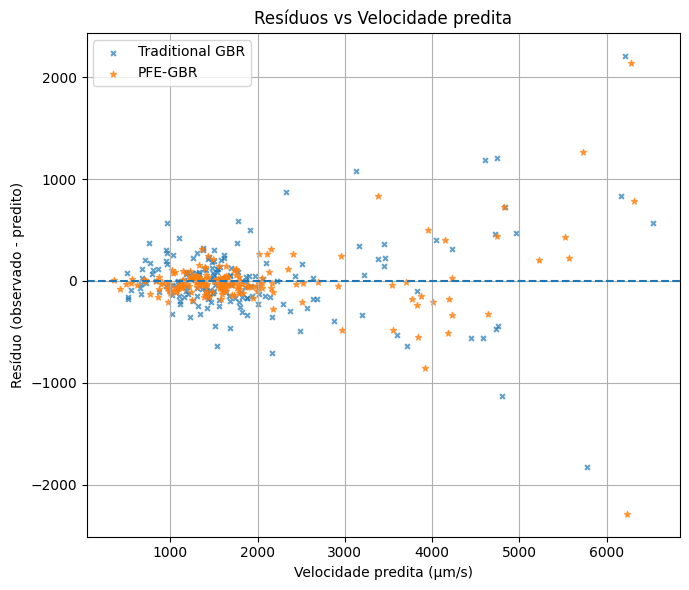

In [28]:
plot_residuals_vs_prediction(df_eval_trad, df_eval_pfe)

# 6. EXPERIMENTO 3 - HOLDOUT + CROSS VALIDATION

**Essa estratégia gera resultados ainda piores! Isso porque é aplicado a cross validation sobre um conjunto ainda menor de dados, definido pelo holdout. Assim, ainda nao alcancei mesmos resultados da tabela 1 do artigo**

In [29]:
def build_evaluation_df(
    y_true,
    y_pred,
    model_name,
    set_name,
    experiment_name=None
):
    """
    Build a tidy evaluation DataFrame with predictions, residuals and metadata.

    Parameters
    ----------
    y_true : array-like or pd.Series
        True target values.
    y_pred : array-like
        Predicted values.
    model_name : str
        Name of the model (e.g., 'Traditional', 'Physics-Informed').
    set_name : str
        Dataset split (e.g., 'train', 'test', 'cv').
    experiment_name : str, optional
        Experiment identifier (e.g., 'exp3').

    Returns
    -------
    pd.DataFrame
    """
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
    })

    df["residuals"] = df["y_true"] - df["y_pred"]
    df["abs_error"] = np.abs(df["residuals"])
    df["model"] = model_name
    df["set"] = set_name

    if experiment_name is not None:
        df["experiment"] = experiment_name

    return df

## Split train and test set

In [30]:
X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## Configuracao experimental


In [31]:
# Cross-validation
model_cv = GradientBoostingRegressor(**GBR_PARAMS)
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Modelo 1 - Tradicional GBR (Baseline)

In [32]:
cv_pred_a_train = cross_val_predict(model_cv, X_train_exp3, y_train_exp3, cv=kfold)
cv_pred_a_test = cross_val_predict(model_cv, X_test_exp3, y_test_exp3, cv=kfold)


In [33]:
df_train = build_evaluation_df(
    y_true=y_train_exp3,
    y_pred=cv_pred_a_train,
    model_name="Traditional",
    set_name="train",
    experiment_name="exp3"
)

df_test = build_evaluation_df(
    y_true=y_test_exp3,
    y_pred=cv_pred_a_test,
    model_name="Traditional",
    set_name="test",
    experiment_name="exp3"
)

df_cv_trad_exp3 = pd.concat(
    [df_train, df_test],
    ignore_index=True
)

In [34]:
mean_absolute_error(y_test_exp3, cv_pred_a_test)

360.7806829834713

## Modelo 2 - PFE - GBR

In [35]:
# Create the transformer
pfe = PhysicsFeatureEngineer(
    use_diameter=False,
    rho_f=RHO_F, 
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_pfe = pfe.fit_transform(X,y)

In [36]:
cv_pred_b = cross_val_predict(model_cv, X_pfe, y, cv=kfold)

In [37]:

# Create evaluation dataframes
df_cv_pfe = pd.DataFrame({
    "y_pred": cv_pred_b,
    "y_true": y.reset_index(drop=True),
    "residuals": y.reset_index(drop=True) - cv_pred_b,
    "model": "PFE"
})


## Comparacao de resultados

In [38]:
# Evaluate CV results
cv_results = pd.DataFrame.from_dict({
    "Traditional GBR (CV)": evaluate(df_cv_trad['y_true'], df_cv_trad['y_pred']),
    "PFE-GBR (CV)": evaluate(df_cv_pfe['y_true'], df_cv_pfe['y_pred'])
}, orient="index")

print(cv_results)

                             MAE        RMSE        R2
Traditional GBR (CV)  234.314568  397.489626  0.886877
PFE-GBR (CV)          135.693109  262.877990  0.950523


# 7. SHAP VALUES - INTERPRETABILIDADE DOS MODELOS

## Abordagem 1 
*Seguindo mesma metodologia do Experimento 2 - Validacao Holdout*

|De acordo com codigo enviado|De acordo com artigo|
|:----|:----|
|nao|nao|

Pipeline de execução
1. carrega os dados 
2. impute values - imputa pela media
3. split train e test
4. faz feature engineering (sem usar diametro)
5. treina o modelo 
6. shap

### Tradicional GBR

In [39]:
# ----------
# 1. carrega os dados 
# obs: no tradicional nao há FE
# ----------
data_, X_, y_ = load_data(FILE_PATH, TARGET_COL)


In [40]:
# ----------
# 2. impute values - exclui nulos
# ----------
X_shap1, y_shap1, imputer_shap1 = handle_missing_values(
    X_,
    y_,
    strategy="impute", 
    impute_method="mean"
)

Imputed missing values using strategy: mean


In [41]:
# ----------
# 3. split train e test
# ----------
X_train_shap1, X_test_shap1, y_train_shap1, y_test_shap1 = train_test_split(
    X_shap1, y_shap1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [42]:
# ----------
# 5. treina o modelo 
# ----------
y_pred_pfe_shap1, trad_gbr_model_shap1 = gbr_train_predict(X_train_shap1, y_train_shap1, X_test_shap1, GBR_PARAMS)


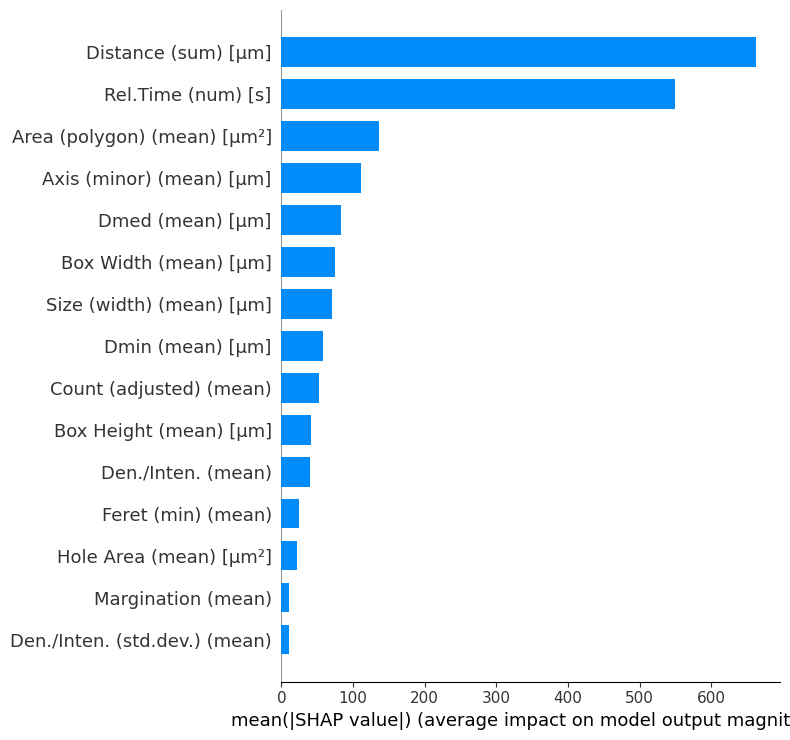

In [43]:
# ----------
# 6. shap
# ----------
explainer = shap.TreeExplainer(
    trad_gbr_model_shap1
)

shap_values = explainer.shap_values(X_test_shap1)

shap.summary_plot(
    shap_values,
    X_test_shap1,
    plot_type="bar",
    max_display=15
)

### PFE - GBR

In [44]:
# ----------
# 1. carrega os dados 
# obs: no tradicional nao há FE
# ----------
data_, X_, y_ = load_data(FILE_PATH, TARGET_COL)


In [45]:
# ----------
# 2. impute values - imputa pela media
# ----------
X_pfe_shap1, y_pfe_shap1, imputer_pfe_shap1 = handle_missing_values(
    X_,
    y_,
    strategy="impute", 
    impute_method="mean"
)

Imputed missing values using strategy: mean


In [46]:
# ----------
# 3. split train e test
# ----------
X_train_pfe_shap1, X_test_pfe_shap1, y_train_pfe_shap1, y_test_pfe_shap1 = train_test_split(
    X_pfe_shap1, y_pfe_shap1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [47]:
# ----------
# 4. Feature Engineering
# ----------
# Create the transformer
pfe_shap1 = PhysicsFeatureEngineer(
    use_diameter=False,
    rho_f=RHO_F,  # Use your constants
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_train_pfe_shap1 = pfe_shap1.fit_transform(X_train_pfe_shap1,y_train_pfe_shap1)
X_test_pfe_shap1 = pfe_shap1.fit_transform(X_test_pfe_shap1,y_test_pfe_shap1)

In [48]:
# ----------
# 5. treina o modelo 
# ----------
y_pred_pfe_shap1, pfe_gbr_model_shap1 = gbr_train_predict(X_train_pfe_shap1, y_train_pfe_shap1, X_test_pfe_shap1, GBR_PARAMS)

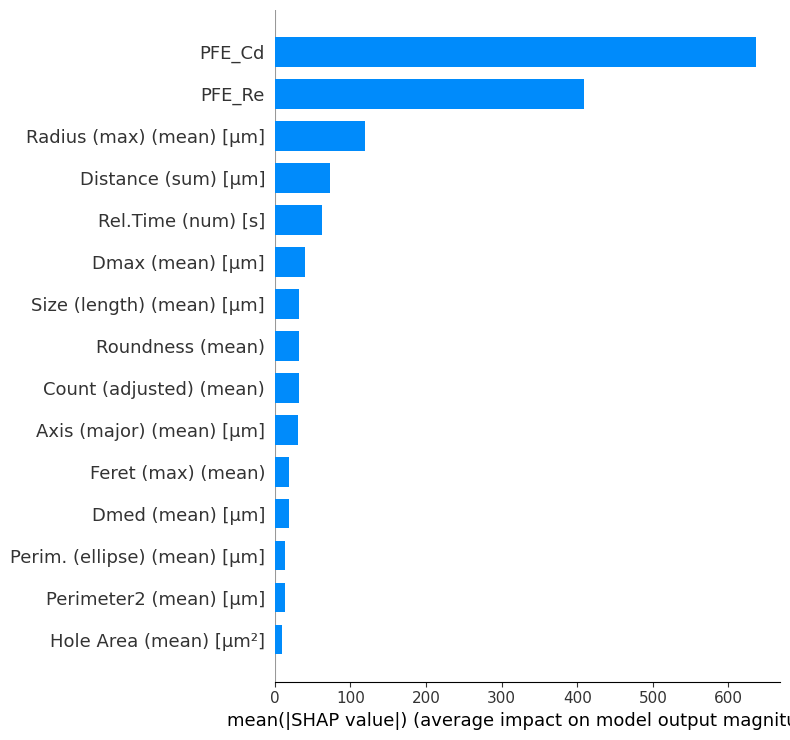

In [49]:
# ----------
# 6. shap
# ----------
explainer = shap.TreeExplainer(
    pfe_gbr_model_shap1
)

shap_values = explainer.shap_values(X_test_pfe_shap1)

shap.summary_plot(
    shap_values,
    X_test_pfe_shap1,
    plot_type="bar",
    max_display=15
)

## Abordagem 2
*Igual ao codigo enviado*

|De acordo com codigo enviado|De acordo com artigo|
|:----|:----|
|sim|nao|

Pipeline de execução
1. carrega os dados e faz feature engineering 
2. impute values - exclui nulos
3. split train e test
4. treina o modelo 
5. shap

### Tradicional GBR

In [50]:
# ----------
# 1. carrega os dados e faz feature engineering 
# obs: no tradicional nao há FE
# ----------
data_, X_, y_ = load_data(FILE_PATH, TARGET_COL)


In [51]:
# ----------
# 2. impute values - exclui nulos
# ----------
X_shap2, y_shap2, imputer_shap2 = handle_missing_values(
    X_,
    y_,
    strategy="drop"
)

Dropped 33 rows with missing values


In [52]:
# ----------
# 3. split train e test
# ----------
X_train_shap2, X_test_shap2, y_train_shap2, y_test_shap2 = train_test_split(
    X_shap2, y_shap2,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [53]:
# ----------
# 4. treina o modelo 
# ----------
y_pred_pfe_shap2, trad_gbr_model_shap2 = gbr_train_predict(X_train_shap2, y_train_shap2, X_test_shap2, GBR_PARAMS)


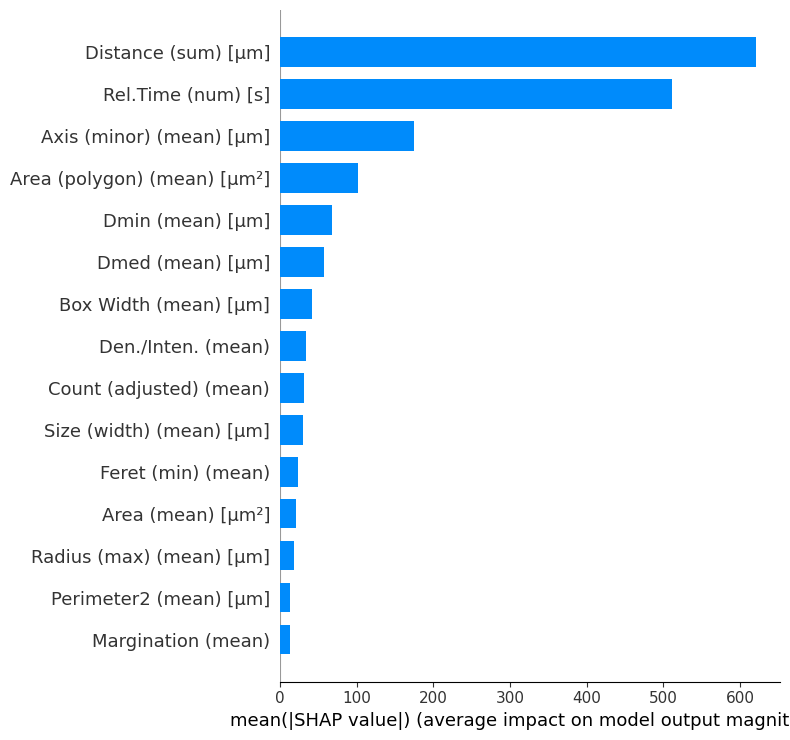

In [54]:
# ----------
# 5. shap
# ----------
explainer = shap.TreeExplainer(
    trad_gbr_model_shap2
)

shap_values = explainer.shap_values(X_test_shap2)

shap.summary_plot(
    shap_values,
    X_test_shap2,
    plot_type="bar",
    max_display=15
)

### PFE - GBR

In [55]:
# ----------
# 1. carrega os dados e faz feature engineering 
# ----------
data_, X_, y_ = load_data(FILE_PATH, TARGET_COL)

# Instancia o transformer
pfe_shap2 = PhysicsFeatureEngineer(
    use_diameter=True,
    rho_f=RHO_F,  # Use your constants
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_pfe_shap2 = pfe_shap2.fit_transform(X_,y_)

In [56]:
# ----------
# 2. impute values - exclui nulos
# ----------
X_pfe_shap2, y_pfe_shap2, imputer_pfe_shap2 = handle_missing_values(
    X_pfe_shap2,
    y_,
    strategy="drop"
)

Dropped 33 rows with missing values


In [57]:
# ----------
# 3. split train e test
# ----------
X_train_pfe_shap2, X_test_pfe_shap2, y_train_pfe_shap2, y_test_pfe_shap2 = train_test_split(
    X_pfe_shap2, y_pfe_shap2,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [58]:
# ----------
# 4. treina o modelo 
# ----------
y_pred_pfe_shap2, pfe_gbr_model_shap2 = gbr_train_predict(X_train_pfe_shap2, y_train_pfe_shap2, X_test_pfe_shap2, GBR_PARAMS)


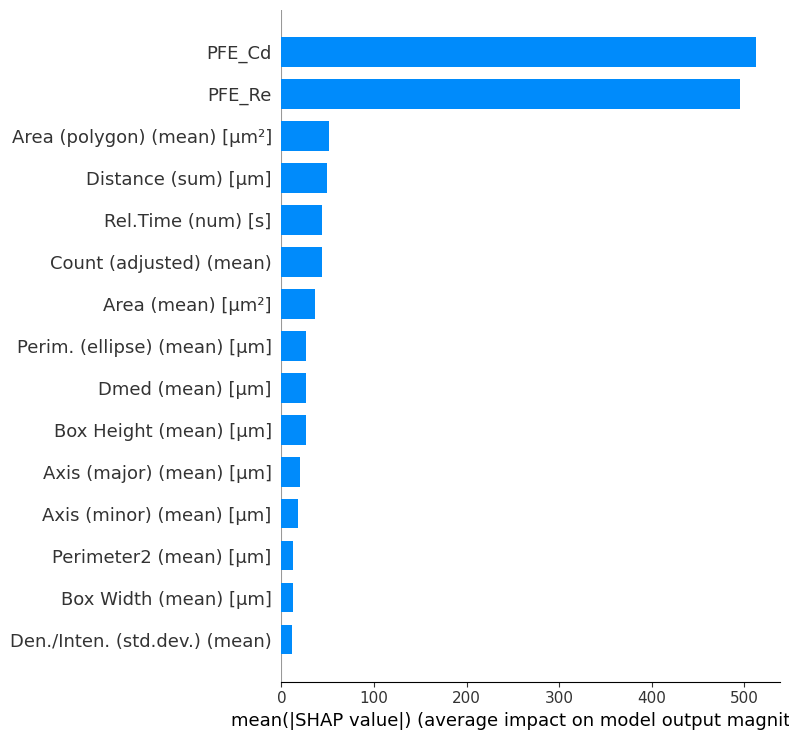

In [59]:
# ----------
# 5. shap
# ----------
explainer = shap.TreeExplainer(
    pfe_gbr_model_shap2
)

shap_values = explainer.shap_values(X_test_pfe_shap2)

shap.summary_plot(
    shap_values,
    X_test_pfe_shap2,
    plot_type="bar",
    max_display=15
)

# 8. ANALISE BOOTSTRAP


|De acordo com codigo enviado|De acordo com artigo|
|:----|:----|
|sim|nao|

Pipeline de execução
1. carrega os dados 
2. faz feature engineering (sem usar diametro)
3. IMPUTE MISSING VALUES - MEAN
4. instancia o modelo e aplica a cross validation 
5. analise bootstrap

*os resultados ficam um pouco diferentes do codigo enviado, porem a diferença é minima, e provavelmente devido a uma truncagem de dados que ocorre nos retornos das funcoes criadas nesse notebook*

In [60]:
# ------------
# 1. carrega os dados
# ------------

data_, X_, y_ = load_data(FILE_PATH, TARGET_COL)

In [61]:
# ------------
# 2. faz feature engineering (sem usar diametro)
# ------------

# Create the transformer
pfe_ = PhysicsFeatureEngineer(
    use_diameter=False,
    use_r2=False,
    rho_f=RHO_F,  # Use your constants
    mu=MU,
    g=G
)

# Fit transform - Physics Feature Engineering
X_pfe_ = pfe_.fit_transform(X_,y_)

In [62]:
# ------------
# 3. Handle missing values
# ------------

X_pfe_, y_, imputer = handle_missing_values(
    X_pfe_,
    y_,
    strategy="impute",
    impute_method="mean",
)

Imputed missing values using strategy: mean


In [63]:
# ------------
# 4. instancia o modelo e aplica a cross validation 
# ------------

pfe_model_cv_ = GradientBoostingRegressor(**GBR_PARAMS)
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_pred_ = cross_val_predict(pfe_model_cv_, X_pfe_, y_, cv=kfold)

# Calculate Metrics for Cross-Validation
cv_mae_ = mean_absolute_error(y_, cv_pred_)
cv_rmse_ = np.sqrt(mean_squared_error(y_, cv_pred_))
cv_r2_ = r2_score(y_, cv_pred_)
# Results
print("5-Fold Cross-Validation Metrics:")
print(f"MAE: {cv_mae_}")
print(f"RMSE: {cv_rmse_}")
print(f"R^2: {cv_r2_}")

5-Fold Cross-Validation Metrics:
MAE: 135.71158843876066
RMSE: 262.89067111736273
R^2: 0.9505177642920191


In [64]:
# ------------
# 5. analise bootstrap
# ------------
bootstrap_results = bootstrap_mae(
    y_true=y_,
    y_pred=cv_pred_,
    n_boot=100,
    random_state=42
)

print("Bootstrap MAE (PFE-GBR)")
print(f"Média: {bootstrap_results['mean_mae']:.2f} µm/s")
print(f"DP:    {bootstrap_results['std_mae']:.2f} µm/s")
print(
    f"IC 95%: "
    f"[{bootstrap_results['ci_low']:.2f}, "
    f"{bootstrap_results['ci_high']:.2f}] µm/s"
)

Bootstrap MAE (PFE-GBR)
Média: 135.75 µm/s
DP:    7.46 µm/s
IC 95%: [123.53, 150.46] µm/s


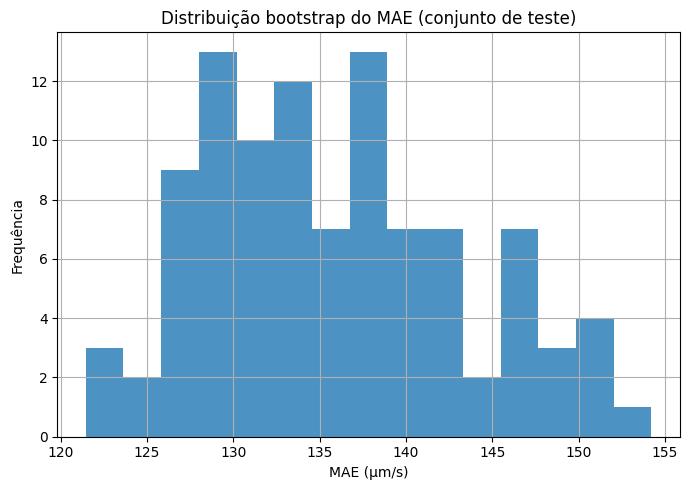

In [65]:
plt.figure(figsize=(7, 5))

plt.hist(
    bootstrap_results["mae_boot"],
    bins=15,
    alpha=0.8
)

plt.xlabel("MAE (µm/s)")
plt.ylabel("Frequência")
plt.title("Distribuição bootstrap do MAE (conjunto de teste)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. ANALISE DE ROBUSTEZ - INJECAO DE RUIDO

|De acordo com codigo enviado|De acordo com artigo|
|:----|:----|
|n/a|nao|

Pipeline de execução
1. carrega os dados 
2. faz feature engineering (sem usar diametro)
3. IMPUTE MISSING VALUES - MEAN
4. instancia o modelo e aplica a cross validation 


In [99]:
noise_levels = [0.01, 0.05, 0.10, 0.20]

results = []

for sigma in noise_levels:
    results.append(
        run_noise_experiment(
            gaussian_level=sigma,
            file_path=FILE_PATH,
            target_col=TARGET_COL,
            gbr_params=GBR_PARAMS,
        )
    )

df_results = pd.DataFrame(results)
print(df_results)

Imputed missing values using strategy: mean
Imputed missing values using strategy: mean
Imputed missing values using strategy: mean
Imputed missing values using strategy: mean
   noise_level         MAE        RMSE        R2
0         0.01  136.515653  262.251019  0.950758
1         0.05  162.709231  286.910870  0.941062
2         0.10  191.681016  314.923688  0.928992
3         0.20  233.634181  372.935223  0.900421


In [100]:
df_results

,noise_level,MAE,RMSE,R2
0,0.01,136.515653,262.251019,0.950758
1,0.05,162.709231,286.910870,0.941062
2,0.10,191.681016,314.923688,0.928992
3,0.20,233.634181,372.935223,0.900421


# 10. ANÁLISE DE ERRO POR CLASSE MORFOLÓGICA